In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import pandas as pd
import csv
import glob
import numpy as np
import matplotlib.pyplot as plt
import converter
import glob
import os
import re

In [3]:
def load_data(path):
    def func(x):
        """Extracts input size from file name"""
        v = x.split(".")[-2].split("-")[-1]
        return int(v)
    
    data = {}

    for filename in glob.iglob(path):
        # extract name
        name = filename.replace("../", "").split(".")[0]

        # read file
        df = pd.read_csv(filename, index_col="Filename")

        # make column names lower-case and remove spaces
        df = df.rename(columns=lambda x: x.strip().lower())    

        # add encoding and message (tyencodepe) columns
        df['format'] = np.where(df.index.str.endswith(".ber"), 'BER', 'XER')
        df['message'] = np.where(df.index.str.contains("data-request"), 'data-request', 'data-response')

        # drop total
        df = df.drop(axis=1, columns=['total'])

        # rename average to the name of this data set
        df = df.rename(columns={"average": name})

        # create input-size parameter
        df['input-size'] = df.index.map(func)

        # save df
        data[name] = df
    
    return data

data = load_data("../*.csv")

In [4]:
def draw(data, xlabel, ylabel, title=None, logy=False, filename=None):
    plt.figure()
    plt.rc('font', family='Liberation Mono')# Latin Modern Mono
    plt.rc('xtick', labelsize='small')
    plt.rc('ytick', labelsize='small')
    ax = data.sort_index().plot(grid=True, logy=logy)
    if title:
        plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    
    plt.show()

# Encoding

In [5]:
encode_xml = data["encode-c"][data["encode-c"]["format"] == 'XER'].sort_values(
    by='input-size'
).drop(['bytes', 'format'], axis=1
      ).rename(columns={'encode-c': 'encode-c-xml'})

encoding = pd.merge(data["encode-python"], data["encode-c"], how='inner').drop(['bytes', 'format'], axis=1)
encoding = pd.merge(encoding, encode_xml, on=['message', 'input-size'], how='inner')
encoding = pd.merge(encoding, data["encode-java"], on=['message', 'input-size'], how='inner').drop(['format', 'bytes'], axis=1)
encoding = encoding.rename(columns={
    'encode-java': 'jASN1',
    'encode-c': 'asn1c',
    'encode-python': 'PyASN1'
})

<Figure size 432x288 with 0 Axes>

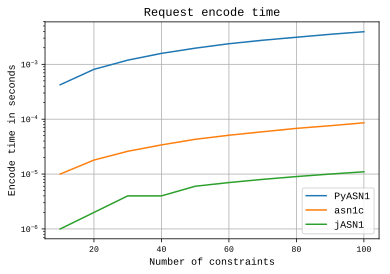

In [6]:
req_enc_time = encoding.where(
    encoding['message'] == 'data-request'
).set_index(
    'input-size'
).drop(
    columns=['message', 'encode-c-xml']
).sort_index()
draw(req_enc_time, "Number of constraints", "Encode time in seconds", "Request encode time", True)
# print((req_enc_time * 1000).to_latex())

<Figure size 432x288 with 0 Axes>

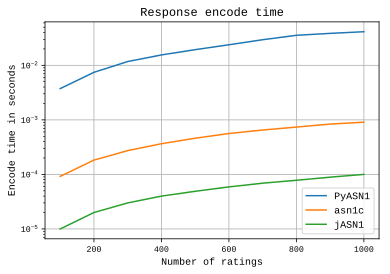

In [7]:
res_enc_time = encoding.where(
    encoding['message'] == 'data-response'
).set_index(
    'input-size'
).drop(
    columns=['message', 'encode-c-xml']
).sort_index()
draw(res_enc_time, "Number of ratings", "Encode time in seconds", "Response encode time", True)

# Decoding

In [8]:
decode_xml = data["decode-c"][data["decode-c"]["format"] == 'XER'].sort_values(
    by='input-size'
).drop(['bytes', 'format'], axis=1
      ).rename(columns={'decode-c': 'decode-c-xml'})

decoding = pd.merge(data["decode-python"], data["decode-c"], how='inner').drop(['bytes', 'format'], axis=1)
decoding = pd.merge(decoding, decode_xml, on=['message', 'input-size'], how='inner')
decoding = pd.merge(decoding, data["decode-java"], on=['message', 'input-size'], how='inner').drop(['format', 'bytes'], axis=1)
decoding = decoding.rename(columns={
    'decode-java': 'jASN1',
    'decode-c': 'asn1c',
    'decode-python': 'PyASN1'
})

<Figure size 432x288 with 0 Axes>

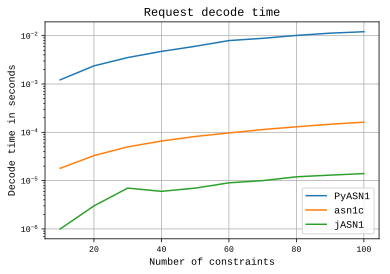

In [9]:
req_dec_time = decoding.where(
    decoding['message'] == 'data-request'
).set_index(
    'input-size'
).drop(
    columns=['message', 'decode-c-xml']
)
draw(req_dec_time, "Number of constraints", "Decode time in seconds", "Request decode time", True)

<Figure size 432x288 with 0 Axes>

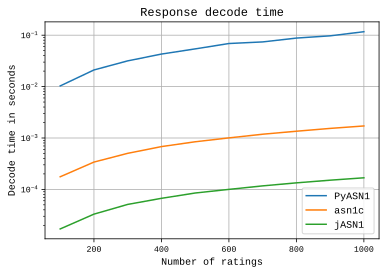

In [10]:
res_dec_time = decoding.where(
    decoding['message'] == 'data-response'
).set_index(
    'input-size'
).drop(
    columns=['message', 'decode-c-xml']
)
draw(res_dec_time, "Number of ratings", "Decode time in seconds", "Response decode time", True)

## Message sizes

In [11]:
files = glob.iglob("../message-*")
sizes = []

for f in files:
    sizes.append({
        'size': int(os.stat(f).st_size),
        'format': f.split(".")[-1].upper(),
        'input-size': int(re.findall(r'\d+', f)[0]),
        'message': 'data-response' if 'data-response' in f else 'data-request'
    })

In [12]:
data_requests = pd.DataFrame(columns=[f.upper() for f in converter.OUTPUT_FORMATS])
for s in sizes:
    if s['message'] == 'data-request':
        index  =  s['input-size']
        format_ = s['format'] 
        value = s['size']
        data_requests.at[index, format_] = int(value)

In [13]:
data_responses = pd.DataFrame(columns=[f.upper() for f in converter.OUTPUT_FORMATS])
for s in sizes:
    if s['message'] == 'data-response':
        index  =  s['input-size']
        format_ = s['format'] 
        value = s['size']
        data_responses.at[index, format_] = int(value)

<Figure size 432x288 with 0 Axes>

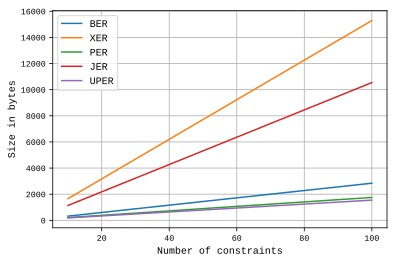

\begin{tabular}{llllll}
\toprule
{} &   BER &    XER &   PER &    JER &  UPER \\
\midrule
10  &   322 &   1656 &   211 &   1138 &   186 \\
20  &   602 &   3171 &   382 &   2183 &   337 \\
30  &   882 &   4686 &   553 &   3228 &   488 \\
40  &  1162 &   6201 &   724 &   4273 &   640 \\
50  &  1442 &   7716 &   896 &   5318 &   791 \\
60  &  1722 &   9231 &  1067 &   6363 &   942 \\
70  &  2002 &  10746 &  1238 &   7408 &  1093 \\
80  &  2282 &  12261 &  1409 &   8453 &  1245 \\
90  &  2562 &  13776 &  1581 &   9498 &  1396 \\
100 &  2842 &  15291 &  1752 &  10543 &  1547 \\
\bottomrule
\end{tabular}



In [15]:
# draw(data_requests, "Number of constraints", "Size in bytes", filename="./data-request-size.pdf")
draw(data_requests, "Number of constraints", "Size in bytes")
data_requests.divide(data_requests["BER"], axis="index").sort_index()
print(data_requests.sort_index().to_latex())

<Figure size 432x288 with 0 Axes>

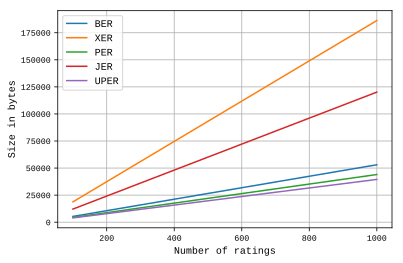

\begin{tabular}{llllll}
\toprule
{} &    BER &     XER &    PER &     JER &   UPER \\
\midrule
100  &   5361 &   18837 &   4444 &   12157 &   3989 \\
200  &  10661 &   37437 &   8845 &   24157 &   7940 \\
300  &  15961 &   56037 &  13245 &   36157 &  11890 \\
400  &  21261 &   74637 &  17645 &   48157 &  15840 \\
500  &  26561 &   93237 &  22045 &   60157 &  19790 \\
600  &  31861 &  111837 &  26445 &   72157 &  23740 \\
700  &  37161 &  130437 &  30845 &   84157 &  27690 \\
800  &  42461 &  149037 &  35245 &   96157 &  31640 \\
900  &  47761 &  167637 &  39645 &  108157 &  35590 \\
1000 &  53061 &  186237 &  44045 &  120157 &  39540 \\
\bottomrule
\end{tabular}



In [18]:
draw(data_responses, "Number of ratings", "Size in bytes") #, filename="./data-response-size.pdf")
data_responses.divide(data_responses["UPER"], axis="index").sort_index()
print(data_responses.sort_index().to_latex())

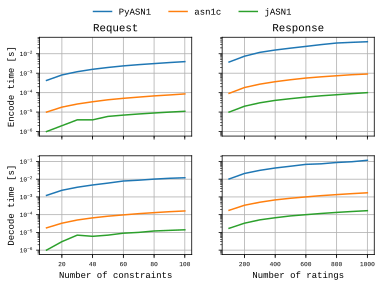

In [19]:
filename = "./encode-decode-ber.pdf"

plt.rc('font', family='Liberation Mono', size=9) # Latin Modern Mono
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
args = {
    "grid": True,
    "logy": True,
    "legend": False
}

req_enc_time.sort_index().plot(ax=ax1, **args)
ax1.set_title("Request")
ax1.set_ylabel("Encode time [s]")

res_enc_time.sort_index().plot(ax=ax2, **args)
ax2.set_title("Response")

req_dec_time.sort_index().plot(ax=ax3, **args)
ax3.set_xlabel("Number of constraints")
ax3.set_ylabel("Decode time [s]")

res_dec_time.sort_index().plot(ax=ax4, **args)
ax4.set_xlabel("Number of ratings")

handles, labels = ax1.get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', ncol=3, frameon=False)

if filename:
    f.savefig(filename, bbox_inches='tight')